In [1]:
import math
import collections
import pickle
import random
import scipy
import json

from matplotlib import pyplot as plt

import GPy
import numpy as np
import pandas as pd
from tqdm import tqdm

# from Kernel import MixtureViaSumAndProduct, CategoryOverlapKernel
from InitialData_Gen import initialize
from AcquisitionFunctions import EI, PI, UCB, AcquisitionOnSubspace
# from SamplingCategorical import compute_prob_dist_and_draw_hts
from UpdateCategoricalWeight import compute_reward_for_all_cat_variable, update_weights_for_all_cat_var
from optimization import sample_then_minimize

from AskTell import ask_tell

from scipy.optimize import minimize

from typing import Union, Tuple
from paramz.transformations import Logexp

1. C - List of number of categroies corresponding to each categorical variable
2. Nc - Number of categorical variables
3. Nx - Continuous variables
4. h - categorical
5. x - continuous
6. z - [h, x]

7. nDim - Nc + Nx
8. bounds - Lower and Upper bounds of both Catergorical variables and continuous variables

9. n_iter - Number of iterations to run the algorithm
10. initN - Number of intial data points
11. batch_size (b) - Number of experiments to be generated in each iteration

12. acq_type - Acquisition Type ('EI', 'LCB', 'ThompsonSampling')

### 1. Load Model background from the pickle file

In [2]:
import sys
myString = sys.path[0]
split_list = myString.split("/")
root = ''
for l in split_list[1:-2]:
    root = root +'/'+ l
    
main_file_path = root + '/HSA_TL/'
carbon_source_fiepath = root + '/'

In [3]:
Stock_solid = pd.read_excel(carbon_source_fiepath + 'CarbonSourceInfo.xlsx', 'Stocks_solid')
Stock_liquid = pd.read_excel(carbon_source_fiepath + 'CarbonSourceInfo.xlsx', 'Stocks_liquid')

Carbon_Names = Stock_solid['Carbon Source'].values.tolist()
Carbon_Names.append(Stock_liquid['Carbon Source'][1])
Carbon_Names.append(Stock_liquid['Carbon Source'][2])

Carbon_Ub = [50]*17 #[g/L]
Carbon_Ub.append(10) # Glycerol [mL/L]
Carbon_Ub.append(50) #Ethanol [mL/L]

OG_Gly_Ub = 100 #[mL/L]
Met_Ub = 100 #[mL/L]

Glu_Ub = 50 #mM
Tween_Ub = 1# 1%
pH_Ub = 6.5# 

Stock_Conc = Stock_solid['g/mL'].values.tolist()
Stock_Conc.append(Stock_liquid['mL/mL'][1].tolist())
Stock_Conc.append(Stock_liquid['mL/mL'][2].tolist())

OG_Stock_Conc = Stock_liquid['mL/mL'][0].tolist()

Glu_Stock_Conc = 250 #mM
Tween_Stock_Conc = 50# %
pH_Stock_Conc = 1# 

In [4]:
property_name1 = 'SP'
property_name2 = 'Specific Productivity'

### 2. Read Experimental condition and results 

In [5]:
#Load a titer quantification file and create the result array
alt_path = root
AllData = pd.read_csv(alt_path +'AllMolecule/HSA_CoCaBO_Prod_AllData.csv')
result = AllData[property_name1].values.reshape(-1,1)

data = AllData.iloc[:,1:5].values

In [6]:
Carbon_mL = []
OG_Gly_mL = []
Met_mL = []

for i in range(data.shape[0]):
    if int(data[i,0]) !=19:
        temp_factor = Carbon_Ub[int(data[i,0])]
    else:
        temp_factor = Carbon_Ub[0]
    temp = data[i,1]/(temp_factor)
    Carbon_mL.append(temp)
    OG_Gly_mL.append(data[i,2]/OG_Gly_Ub * 1000/100)
    Met_mL.append(data[i,3]/Met_Ub*1000/100)
    
data_sc = np.concatenate((data[:,0:1],np.array(Carbon_mL).reshape(-1,1),
                          np.array(OG_Gly_mL).reshape(-1,1), np.array(Met_mL).reshape(-1,1)), axis = 1)

data_sc = np.concatenate((data_sc, 
                          1e-5 * np.ones((AllData.shape[0],4)), 
                          0.999 * np.ones((AllData.shape[0],1))), axis = 1)



In [7]:
#Load a titer quantification file and create the result array
N_round = 4
Design = {}
Result_df = {}
for nr in range(N_round):
    file_name = main_file_path + 'Codes/Round' + str(nr) + '/Reconstructed_Round' + str(nr) + '.csv'
    Design[nr] = pd.read_csv(file_name)
    Column_Names = pd.read_csv(file_name).columns
    file_name_res = main_file_path + 'Exp/Round' + str(nr) + '/Round' + str(nr) + '_Result_Summary_final.csv'
    Result_df[nr] = pd.read_csv(file_name_res)
    fac = int(Result_df[nr].shape[0]/Design[nr].shape[0])
    temp = np.repeat(Design[nr].iloc[:-1,1:].values,fac, axis = 0)
#     print(temp)
# #     for j in range(Design[nr].shape[0]):
#         temp = np.repeat(Design[nr].iloc[:,1:].values,2, axis = 0)
    des_bench = np.concatenate((np.arange(0,19).reshape(-1,1), 
                                            np.zeros((19,1)), 0.4 * np.ones((19,1)), 
                                            0.15*np.ones((19,1)),
                                           1e-5 * np.ones((19,4)), 
                                  0.999 * np.ones((19,1))), axis = 1)
    
    data_sc = np.concatenate((data_sc, temp, des_bench), axis = 0) #, temp, temp, temp,
    res_temp = Result_df[nr][property_name2].iloc[:-2,].values.reshape(-1,1)
    result = np.concatenate((result, res_temp, #, res_temp,res_temp, res_temp,  
                             Result_df[nr]['Specific Productivity'].iloc[-1,]*np.ones((19,1))), axis = 0)
    
mu_y = np.mean(result, 0)
std_y = np.std(result, 0)

mu_x = np.mean(data_sc, 0)
std_x = np.std(data_sc, 0)

data_norm = (data_sc - mu_x)/std_x
data_norm[:,0] = data_sc[:,0]

result_norm = (result - mu_y)/std_y

Error attained in last to last round - 3.7
Error attained in last round - 1.8
Min expected RMSEP computed from training std (0.54)

In [8]:
background_file = main_file_path +  "Codes/Round3/3_ModelBackground.pkl"
with open(background_file, "rb") as fp:
    ModelBackground_0 = pickle.load(fp)
    

ModelBackground_0['data_param']['trade_off'] = 3 #3 * (1.8-0.54)/(3.7 - 0.54) 


ModelBackground_0['data_param']['Meas_Noise'] = 0.1

### 3. First iteration to ask the algorithm

In [9]:
batch_size = 11

random.seed(0)

z_next, Categorical_dist_param, gp_actual = ask_tell(data_sc, result, ModelBackground_0['data_param'], 
                                          'Matern52', 'constant_liar',  batch_size, 
                                           ModelBackground_0['Categorical_dist_param']['Wc_list'],  
                                          ModelBackground_0['gamma_list']) #_pure

check2
0
[10.          0.22661467  0.36364091  0.48871935  0.55786114  0.71120186
  0.45046571  0.14292991  0.98416715]
1
[13.          0.49130354  0.07497206  0.57215307  0.16804331  0.86403258
  0.51478346  0.75451979  0.90326675]
2
[9.         0.12979855 0.18352143 0.71837773 0.04955031 0.30940641
 0.55336662 0.07823327 0.90750246]
3
[14.          0.53483685  0.20670799  0.66034856  0.39434146  0.7444141
  0.36246404  0.76608378  0.96270149]
4
[15.          0.65297155  0.14764599  0.59715813  0.48424939  0.74548723
  0.42770185  0.53821421  0.90759342]
5
[13.          0.76506046  0.31536621  0.50801945  0.34973769  0.67463579
  0.29201515  0.78935348  0.92273592]
6
[8.         0.19486163 0.00856224 0.52297368 0.1333804  0.22604406
 0.65789994 0.36961817 0.88494166]
7
[9.         0.25029086 0.39675267 0.75230717 0.11695462 0.20391902
 0.34338103 0.18153939 0.94346235]
8
[14.          0.61669854  0.20052956  0.26541279  0.41610857  0.83918378
  0.60090584  0.71330657  0.91242711]
9
[7

In [10]:
pd.DataFrame(z_next).to_csv('./Round4/4_ExperimentalDesign.csv')

### 4. Store the Model background parameters

In [11]:
ModelBackground_1 = {}
ModelBackground_1 = {'gamma_list': ModelBackground_0['gamma_list'],  'budget': ModelBackground_0['budget'],
                 'bestUpperBoundEstimate': ModelBackground_0['bestUpperBoundEstimate'], 
                    'data_param': ModelBackground_0['data_param'], 
                   'Categorical_dist_param': Categorical_dist_param}

import pickle
with open('./Round4/4_ModelBackground.pkl', 'wb') as output:
    # Pickle dictionary using protocol 0.
    pickle.dump(ModelBackground_1, output)

### 5. Conversion to actual experimental execution

In [12]:
Selected_Carbon = []
Carbon_mL = []
OG_Gly_mL = []
Met_mL = []
Glu_OG_mL = []
Tween_OG_mL = []
Glu_Prod_mL = []
Tween_Prod_mL = []
pH_mL = []

for i in range(batch_size):
    Selected_Carbon.append(Carbon_Names[int(z_next[i,0])])
    temp_factor = Carbon_Ub[int(z_next[i,0])]/ Stock_Conc[int(z_next[i,0])]
    temp = z_next[i,1] * temp_factor * 3
    # [g/L]/[g/mL] * [mL] --> g * mL * mL/[L * g] --> 10^-6 L --> uL 
    Carbon_mL.append(temp)
    # [mL]*[mL/L] --> 10^-6 L --> 1 uL 
    OG_Gly_mL.append(z_next[i,2] * OG_Gly_Ub * 3/OG_Stock_Conc)
    Met_mL.append(z_next[i,3] * Met_Ub * 3)
    
    Glu_OG_mL.append(z_next[i,4] * Glu_Ub * 3 * 1000/Glu_Stock_Conc) # uL
    Tween_OG_mL.append(z_next[i,5] * Tween_Ub * 3 * 1000/Tween_Stock_Conc) #uL
    Glu_Prod_mL.append(z_next[i,6] * Glu_Ub * 3 * 1000/Glu_Stock_Conc) # uL
    Tween_Prod_mL.append(z_next[i,7] * Tween_Ub * 3 * 1000/Tween_Stock_Conc) #uL
    pH_mL.append(z_next[i,8] * pH_Ub ) #* 3/pH_Stock_Conc
    


Experiment_1_3mL = {'Carbon_Type': Selected_Carbon,
               'Conc_Carbon [uL]': Carbon_mL,
               'Gly_OG [uL]': OG_Gly_mL,
               'Met_Prod [uL]': Met_mL,
                'Glu_OG [uL]' :Glu_OG_mL,
                'Tween_OG [uL]':Tween_OG_mL,
                'Glu_Prod [uL]': Glu_Prod_mL ,
                'Tween_Prod [uL]': Tween_Prod_mL ,  
                  'pH': pH_mL }

pd.DataFrame(Experiment_1_3mL).to_csv('./Round4/4_ExperimentPlan_mLValue_3mL.csv')

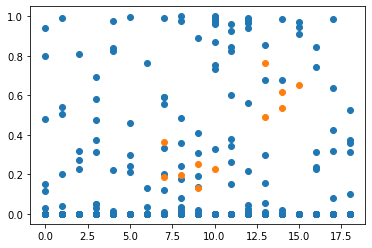

In [13]:
plt.scatter(data_sc[:,0], data_sc[:,1])
plt.scatter(z_next[:,0],z_next[:,1])

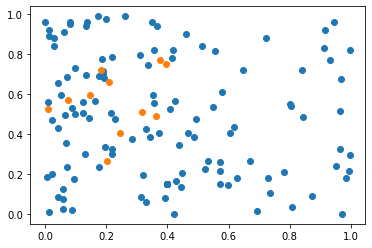

In [14]:
plt.scatter(data_sc[:,2], data_sc[:,3])
plt.scatter(z_next[:,2],z_next[:,3])

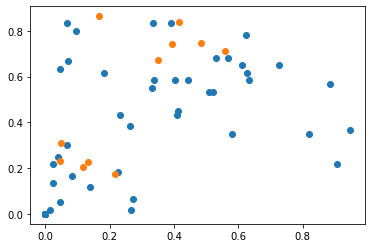

In [15]:
plt.scatter(data_sc[:,4], data_sc[:,5])
plt.scatter(z_next[:,4],z_next[:,5])

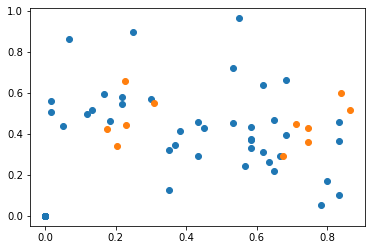

In [16]:
plt.scatter(data_sc[:,5], data_sc[:,6])
plt.scatter(z_next[:,5],z_next[:,6])

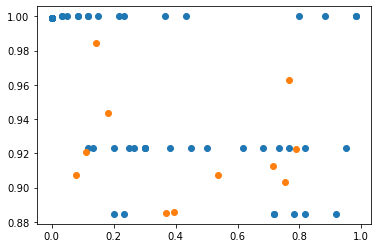

In [17]:
plt.scatter(data_sc[:,7], data_sc[:,8])
plt.scatter(z_next[:,7],z_next[:,8])

In [18]:
pd.DataFrame(Experiment_1_3mL).to_csv('./Round4/Actual_Round4_3mL.csv')